<a href="https://colab.research.google.com/github/ssykra/ssykra.github.io/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MOUNT FOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


UPLOAD DATASET

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wXNi0BvxVZacbjsPWqTi")
project = rf.workspace("sarahrambe").project("tilapia-condition-ldiht")
version = project.version(1)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tilapia-Condition-1 in folder:: 100%|██████████| 2666/2666 [00:10<00:00, 264.40it/s]


IMPORT LIBRARY

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dropout
import random
import cv2

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams['font.size'] = 14

1. EXPLOR DATA

In [5]:
path = "/content/Tilapia-Condition-1/train"

In [25]:
names = []
nums = []
data = {'kelas':[],'samples':[]}

for i in os.listdir(path+'/'):
    nums.append(len(os.listdir(path+'/'+i)))
    names.append(i)

data['kelas']+=names
data['samples']+=nums

df = pd.DataFrame(data)
df.sort_values(by='kelas',inplace=True)
df.reset_index(inplace=True)
df= df.drop('index', axis=1)
df

,kelas,samples
0,Segar,1172
1,Tidak Segar,1172


In [7]:
path = "/content/Tilapia-Condition-1/valid"

In [8]:
names = []
nums = []
data = {'kelas':[],'samples':[]}

for i in os.listdir(path+'/'):
    nums.append(len(os.listdir(path+'/'+i)))
    names.append(i)

data['kelas']+=names
data['samples']+=nums

df = pd.DataFrame(data)
df.sort_values(by='kelas',inplace=True)
df.reset_index(inplace=True)
df= df.drop('index', axis=1)
df

,kelas,samples
0,Segar,122
1,Tidak Segar,140


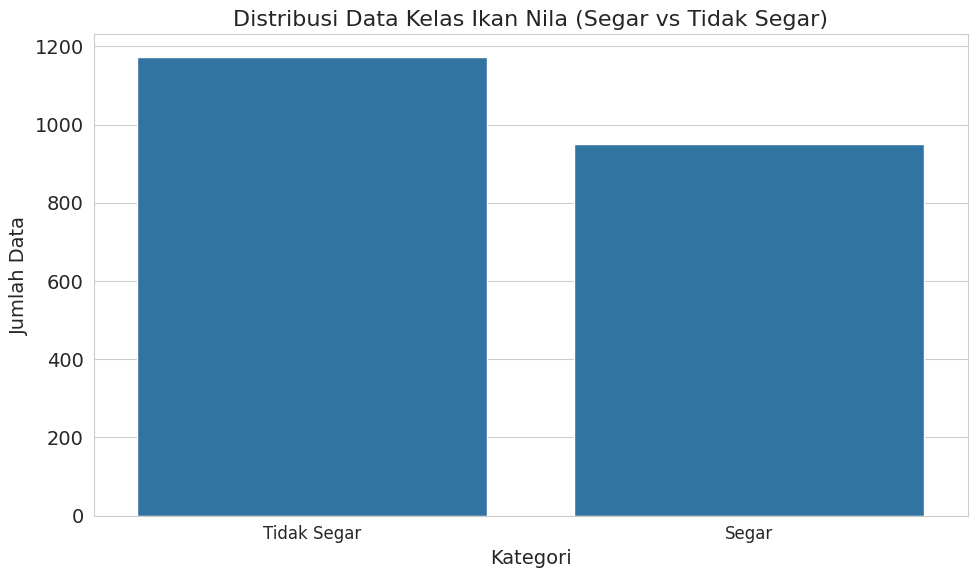

In [9]:
# Path ke folder train
train_path = '/content/Tilapia-Condition-1/train'

# Ambil daftar kelas
categories = os.listdir(train_path)

# Hitung jumlah gambar per kelas
category_counts = []

for category in categories:
    category_path = os.path.join(train_path, category)
    if os.path.isdir(category_path):
        count = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        category_counts.append((category, count))

# Buat DataFrame
data = pd.DataFrame(category_counts, columns=['kelas', 'samples'])

# Plot
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='kelas', y='samples', data=data)
plt.xticks(rotation=0, fontsize=12)
plt.ylabel('Jumlah Data', fontsize=14)
plt.xlabel('Kategori', fontsize=14)
plt.title('Distribusi Data Kelas Ikan Nila (Segar vs Tidak Segar)', fontsize=16)
plt.tight_layout()
plt.show()

1.1 VISUALISASI DATA

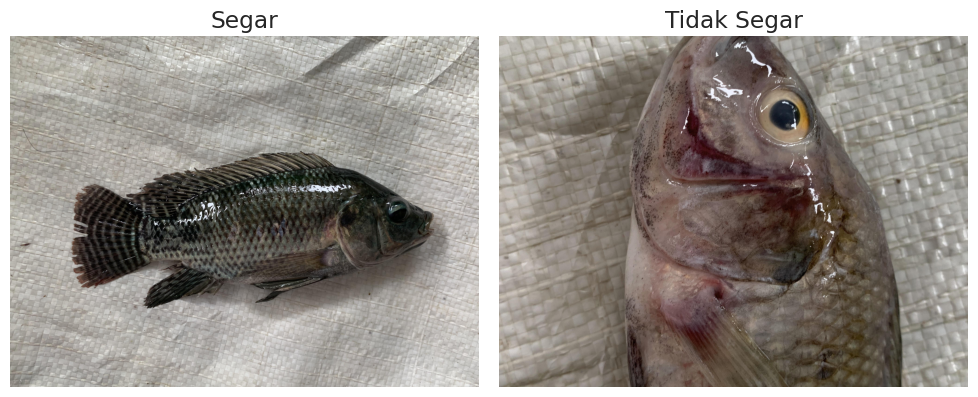

In [11]:
path = '/content/Tilapia-Condition-1/train'
classes = ['Segar', 'Tidak Segar']

plt.figure(figsize=(10, 5))

for i, cls in enumerate(classes):
    class_path = os.path.join(path, cls)
    images = os.listdir(class_path)

    if len(images) == 0:
        continue

    img_name = random.choice(images)
    img_path = os.path.join(class_path, img_name)
    image = cv2.imread(img_path)

    if image is None:
        continue

    # Normalisasi dan whitening
    normalized = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    whitening = cv2.cvtColor(normalized, cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(whitening, 1.5, whitening, -0.5, 0)

    plt.subplot(1, 2, i + 1)
    plt.imshow(result)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

2. PREPROCESSING

In [12]:
batch_size = 32
img_size = 224

train_dir = '/content/Tilapia-Condition-1/train'
val_dir = '/content/Tilapia-Condition-1/valid'

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0
)

train_generator = image_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

val_generator = image_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

Found 2121 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [13]:
print(val_generator[0][0].shape)

(32, 224, 224, 3)


In [14]:
[key for key in train_generator.class_indices]

['Segar', 'Tidak Segar']

2.1 HASIL PREPROCESSING

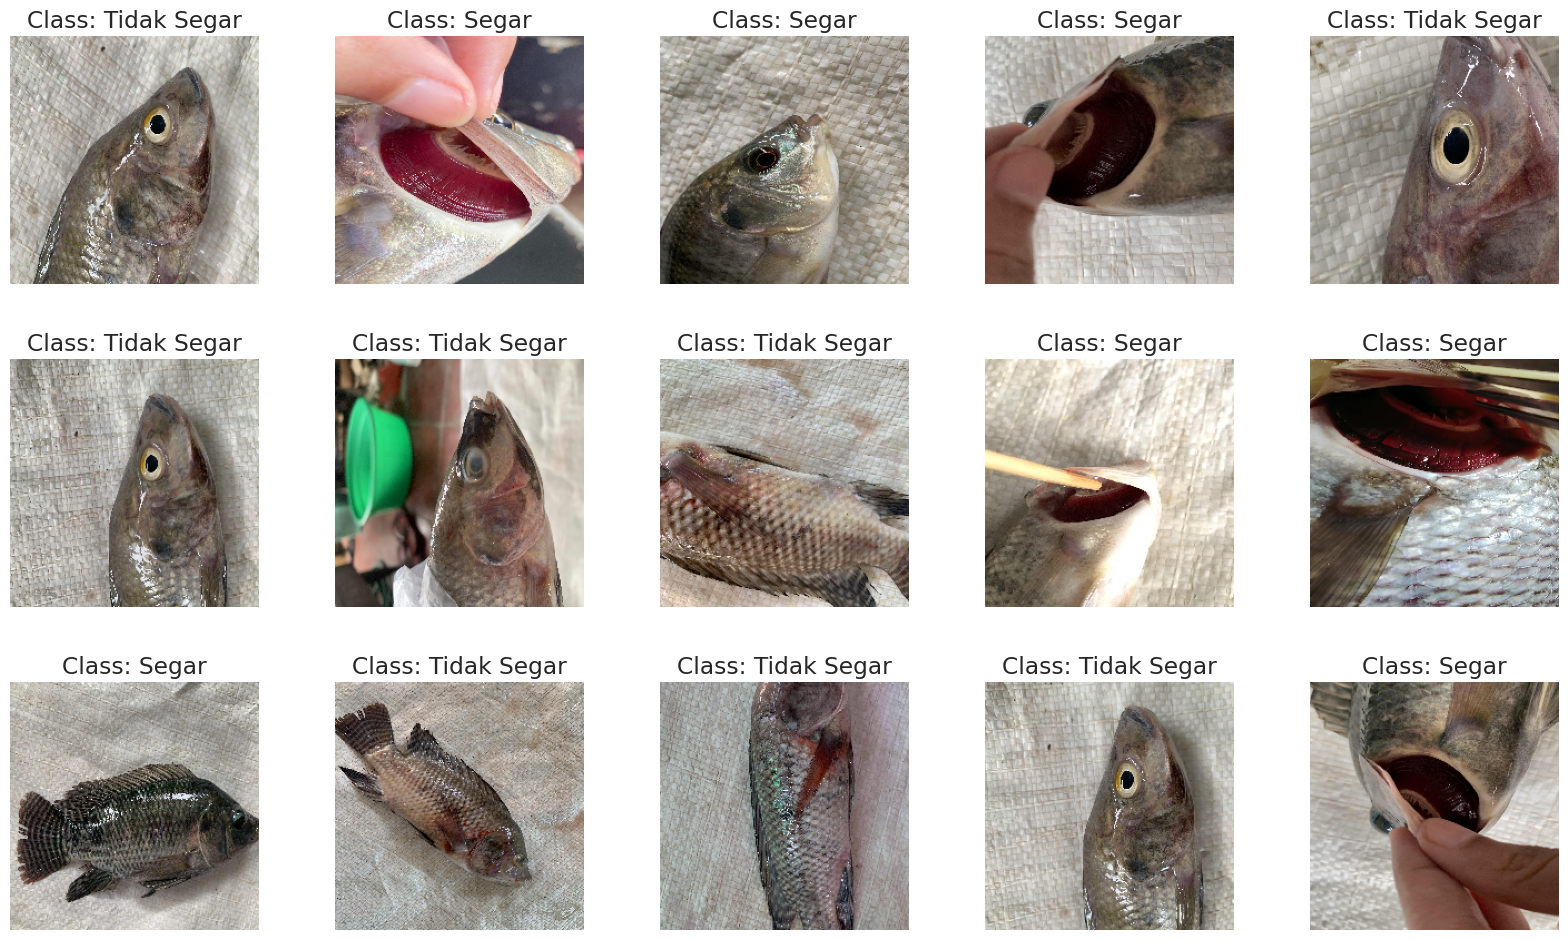

In [15]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]

plt.figure(figsize=(20, 20))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    label_index = int(titles[i])  # karena class_mode='binary'
    plt.title(f'Class: {labels[label_index]}')
    plt.axis("off")
plt.show()

3. AUGMENTASI

3.1 OVERSAMPLING KELAS SEGAR DATA TRAIN

In [23]:
import os
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

seg_path = "/content/Tilapia-Condition-1/train/Segar"

save_path = "/content/drive/MyDrive/Augmented_Tilapia/train/Segar"
os.makedirs(save_path, exist_ok=True)

target_count = 1172

original_imgs = [f for f in os.listdir(seg_path) if f.endswith('.jpg')]
n_original = len(original_imgs)
n_to_generate = target_count - n_original

if n_to_generate <= 0:
    print("Jumlah gambar sudah seimbang atau melebihi, tidak perlu augmentasi.")
else:
    aug_gen = ImageDataGenerator(
        rotation_range=15,
        zoom_range=[1.0, 1.1],
        brightness_range=[0.9, 1.1],
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    generated = 0
    save_prefix = "aug"

    print(f"Melakukan augmentasi sebanyak {n_to_generate} gambar...")

    while generated < n_to_generate:
        for img_name in original_imgs:
            if generated >= n_to_generate:
                break
            img_path = os.path.join(seg_path, img_name)
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in aug_gen.flow(x, batch_size=1, save_to_dir=save_path, save_prefix=save_prefix, save_format='jpg'):
                generated += 1
                gc.collect()
                break

    print(f"{generated} gambar augmentasi berhasil ditambahkan.")

Melakukan augmentasi sebanyak 3 gambar...
3 gambar augmentasi berhasil ditambahkan.


In [24]:
import shutil
import os

augmented_path = "/content/drive/MyDrive/Augmented_Tilapia/train/Segar"
original_path = "/content/Tilapia-Condition-1/train/Segar"

for filename in os.listdir(augmented_path):
    if filename.endswith(".jpg"):
        src_path = os.path.join(augmented_path, filename)
        dst_path = os.path.join(original_path, filename)
        shutil.move(src_path, dst_path)

print("Pindah file selesai")

Pindah file selesai


3.2 AUGMENTASI SEMUA KELAS DI DATA TRAIN

In [26]:
import os
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

base_path = '/content/Tilapia-Condition-1/train'
class_folders = ['Segar', 'Tidak Segar']
target_size = (224, 224)
num_aug_per_img = 10

aug_gen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=[1.0, 1.1],
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    images = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    print(f"\nMulai augmentasi untuk folder: {cls} | Total gambar asli: {len(images)}")

    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        count = 0
        for batch in aug_gen.flow(
            x,
            batch_size=1,
            save_to_dir=folder_path,
            save_prefix='aug',
            save_format='jpg'
        ):
            count += 1
            gc.collect()
            if count >= num_aug_per_img:
                break

    print(f"Augmentasi selesai untuk kelas {cls}. Total ditambahkan: {len(images) * num_aug_per_img} gambar.")


Mulai augmentasi untuk folder: Segar | Total gambar asli: 1172
Augmentasi selesai untuk kelas Segar. Total ditambahkan: 11720 gambar.

Mulai augmentasi untuk folder: Tidak Segar | Total gambar asli: 1172
Augmentasi selesai untuk kelas Tidak Segar. Total ditambahkan: 11720 gambar.


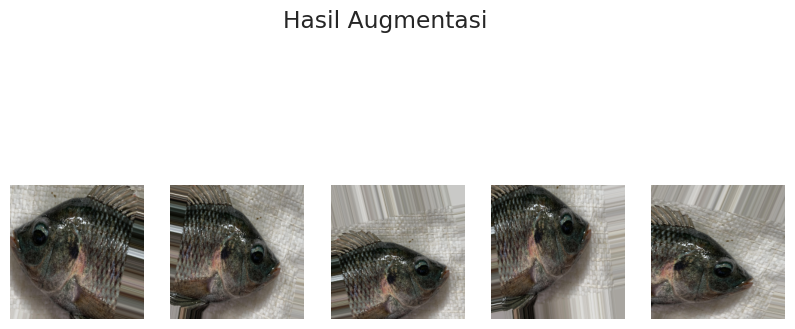

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
import numpy as np

# 1. Inisialisasi ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Load 1 gambar
img_path = "/content/Tilapia-Condition-1/train/Segar/mata_segar_day1_001_jpg.rf.3a4563f16806e3c180ac20fe404a870e.jpg"  # ganti sesuai gambar kamu
img = load_img(img_path, target_size=(224, 224))  # resize ke ukuran model
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  # reshape ke batch

# 3. Tampilkan hasil augmentasi (misal 5 contoh)
plt.figure(figsize=(10, 5))
i = 0
for batch in datagen.flow(x, batch_size=1):
    aug_img = array_to_img(batch[0])
    plt.subplot(1, 5, i + 1)
    plt.imshow(aug_img)
    plt.axis('off')
    i += 1
    if i >= 5:
        break

plt.suptitle("Hasil Augmentasi")
plt.show()

In [28]:
import shutil
import os

src_path = "/content/Tilapia-Condition-1"
dst_path = "/content/drive/MyDrive/Tilapia-Condition-1"

os.makedirs(dst_path, exist_ok=True)

for item in os.listdir(src_path):
    s = os.path.join(src_path, item)
    d = os.path.join(dst_path, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print("Pindah file selesai")

Pindah file selesai
